In [120]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

sns.set(rc={'figure.figsize':(12,8)})

#  Анализ факторов, определяющих успешность игры.

### Описание:

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### План:
1. Загрузка данных, проверка корректности
2. Преобработка данных (пропуски, дубликаты и т.д)
3. Ислледовательский анализ данных (Необходимо выявиять основные тенденции факторов в различных регионах)
4. Необходимо проверить предоставленные гипотезы.
5. Написать вывод, который поможет узнать, какие факторы являеются определяющими успешность игры

### Гипотезы для проверки
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

# Ход работы

### 1. Загрузка данных

#### Данные:
Данные представляют собой набор из 16715 игр за период с 1980-2016 гг. Со следующими атрибутами:
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


In [121]:
df = pd.read_csv("https://code.s3.yandex.net/datasets/games.csv")
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Вывод
В результате загрузки данных были

Обнаружены пропуски в следующих параметрах:
* Name
* Year_of_Release
* Genre
* Critic_Score
* User_Score
* Rating

Выявлены некорректные типы данных для следующих параметров:
* Year_of_Release
* Critic_Score
* User_Score

Даны некорректные название атрибутов. **Данные требует предобработки**

### 2. Предобработка данных

#### Приведение названий столбцов к нижнему регистру

In [123]:
new_columns = [x.lower() for x in df.columns.tolist()]
df.columns = new_columns
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

#### Приведение типов к корректным:
    year_of_realese - подразумевает год выхода игры, необходимо привести к типу int.
    user_score - подразумеват оценку среди игроков, необходимо привести к типу float.

In [124]:
# Т.к в year_of_release содержатся неизвестные года релиза, зменим их на 0.
df['year_of_release'] = df['year_of_release'].fillna(0)
# Приведем столбец к типу int
df['year_of_release'] = df['year_of_release'].astype(int)

    В столбце user_score часто встречается значение tbd
    Из открытых источников tbd - означает, что игра не имеет оценки по тем или иным причинам.
    Поэтому решено заменить значение на NaN. В данном исследовании это будет означать отсутствие оценки.

In [125]:
# Проверка какие данные есть в user_score
print(df['user_score'].value_counts().sort_index())
df['user_score'] = df['user_score'].replace("tbd", np.nan)
# df['user_score'] = df['user_score'].fillna(0)
df['user_score'] = df['user_score'].astype(float)

user_score
0         1
0.2       2
0.3       2
0.5       2
0.6       2
       ... 
9.4      11
9.5       6
9.6       2
9.7       1
tbd    2424
Name: count, Length: 96, dtype: int64


In [126]:
df['critic_score'].value_counts().sort_index()

critic_score
13.0     1
17.0     1
19.0     6
20.0     3
21.0     1
        ..
94.0    37
95.0    16
96.0    18
97.0    11
98.0     4
Name: count, Length: 82, dtype: int64

Т.к наименьшее значение в critic_score не равно 0, то можно взять это значение для замены на него неизвестных значений

In [127]:
df['critic_score'] = df['critic_score'].fillna(0)
df['critic_score'] = df['critic_score'].astype(int)

#### Обработка пропусков
Пропуски, которые можно удалить т.к количество пропусков очень мало:

    name
    genre
    
Также необходимо обратботать столбец rating

In [128]:
df = df.dropna(subset=['name', 'genre']).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  int64  
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.4+ MB


In [129]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Из открытых источников известно, что Рейтинг E и K-A - одно и то же, а RP - значит, что на данный момент игре не присвоен никакой рейтинг, поэтому неизвестные значение можно заменить на RP.

In [130]:
df['rating'] = df['rating'].replace("K-A", "E").fillna("RP")
df['rating'].unique()

array(['E', 'RP', 'M', 'T', 'E10+', 'AO', 'EC'], dtype=object)

#### Создание новых атрибутов

Создание столбца с общими продажми по всем регионам позволит проще находить популярные игры.

In [131]:
df['all_sales'] = df['other_sales'] + df['na_sales'] + df['eu_sales'] + df['jp_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,NaN,RP,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,NaN,RP,31.38


#### Проверка на дубликаты

In [132]:
df[df.duplicated()].sum().sum()

0.0

Количество явных дубликатов в данных равно нулю, но необходимо проверить столбец name

In [133]:
df[df['name'].duplicated()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
35,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83,4.8,M,13.68
37,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,5.54,5.73,0.49,1.57,88,3.2,M,13.33
41,Call of Duty: Black Ops,PS3,2010,Shooter,5.99,4.37,0.48,1.79,88,6.4,M,12.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16704,Men in Black II: Alien Escape,GC,2003,Shooter,0.01,0.00,0.00,0.00,0,NaN,T,0.01
16707,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.00,0.00,0,NaN,RP,0.00
16708,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,0,NaN,RP,0.01
16711,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,0,NaN,RP,0.01


Было обнаружено очень много дубликатов, но это связано с тем, что одна и та же игра может выпускаться под разные платформы и соответственно иметь разные продажи и оценки. Поэтому необходимо проверить дубликаты в названии, платформе и дате

In [134]:
df = df.drop_duplicates(['name', 'platform','year_of_release']).reset_index(drop=True)
df[df[['name', 'platform', 'year_of_release']].duplicated()].count().sum()

0

#### Итоги предобработки данных:

В ходе предобработки данных 

    Была выявлена и исправлена неверная типизация в столбцах
    Были обнаружены и заменены пропуски
    Удалены данные, которые не возможно анализировать.
    Удалены дубликаты данных

### Исследовательский анализ

    Рассмотрим сколько игр выпускалось в каждом году

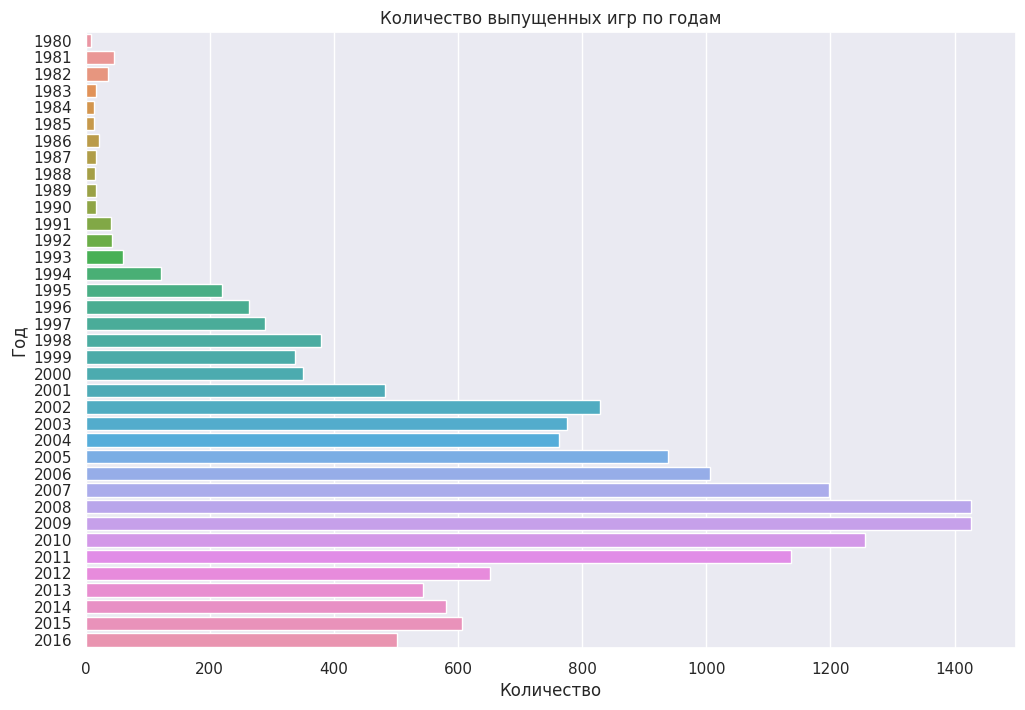

In [135]:
count_by_year = pd.pivot_table(df[df['year_of_release'] != 0], index='year_of_release', aggfunc={'name':'count'})
count_by_year.columns = ['count']
sns.barplot(data=count_by_year, y=count_by_year.index, x='count', orient='h')
plt.xlabel("Количество")
plt.ylabel("Год")
plt.title("Количество выпущенных игр по годам")
plt.show()

На графике видно, что до 1991 года, количество выпущенных игр было очень мало и практически никак не изменялось, однако начиная с 1991 г. наблюдает рост количества выпущенных игр.

    

    Рассмотрим какие платформы были самыми популярные в каждом году

In [136]:
top_platform = (df[
        (df['year_of_release'] >= 2000) & df['platform'].isin(['PS2', 'PS3', 'DS', 'PSP', 'Wii'])]
        .pivot_table(index=['year_of_release', 'platform'], values='name', aggfunc='count'))
top_platform = top_platform.reset_index()
top_platform.columns = ['year', 'platform', 'count']
top_platform.head()

,year,platform,count
0,2000,PS2,82
1,2001,PS2,185
2,2002,PS2,280
3,2003,PS2,256
4,2004,DS,23


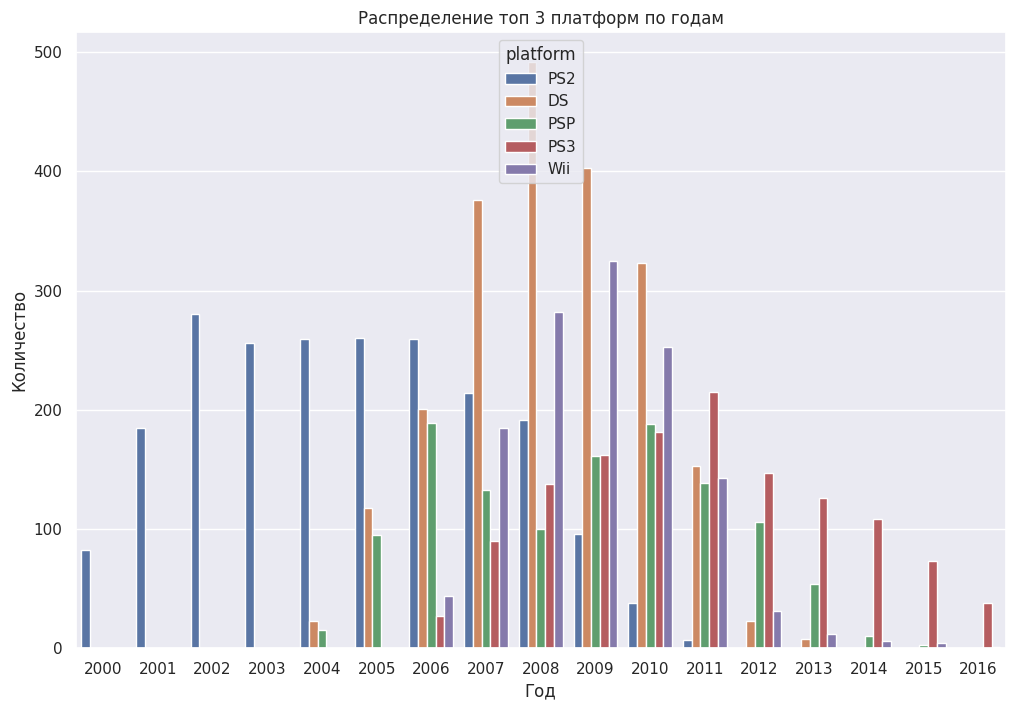

In [137]:
sns.barplot(top_platform, x='year', y='count', hue='platform')
plt.xlabel("Год")
plt.ylabel("Количество")
plt.title("Распределение топ 3 платформ по годам")
plt.show()

По графику видно, что каждые несколько лет происходит смена популярных платформ (в будущем я буду называть поколение), это вполне логично, т.к идет постоянное развитие и вскоре выпускается новая платформа, которая поддерживает более современные игры. К примеру:
* DS (2006 - 2011)
* Wii (2007 - 2010)
* 
Также по графику видно, что с **2014** года, началось новое поколение и имеет смысмл для дальнейшего исследования взять данные именно за **2014 - 2015 г - Актуальный период**.

In [138]:
actual_data = df[(df['year_of_release'] == 2015) | (df['year_of_release'] == 2014)]
print(f"Количество игр: {actual_data.shape[0]}")

Количество игр: 1187


Таким образом мы получаем данные о 1187 играх, однако уникальных игр, кончено, меньше т.к многие выпускаются не только на одну платформу, но это не является проблемой, т.к нам необходимо найти факторы, которые влияют на успешность игры. Возможно одна и та же игра на разных платформах имеет разные оценки и продажи.

In [139]:
pt = pd.pivot_table(actual_data, index=['year_of_release', 'platform'], aggfunc={'name':'count'})
pt.reset_index(inplace=True)
pt['year_of_release'] = pt['year_of_release'].astype(int)
pt

,year_of_release,platform,name
0,2014,3DS,80
1,2014,PC,47
2,2014,PS3,108
3,2014,PS4,75
4,2014,PSP,10
5,2014,PSV,100
6,2014,Wii,6
7,2014,WiiU,31
8,2014,X360,63
9,2014,XOne,61


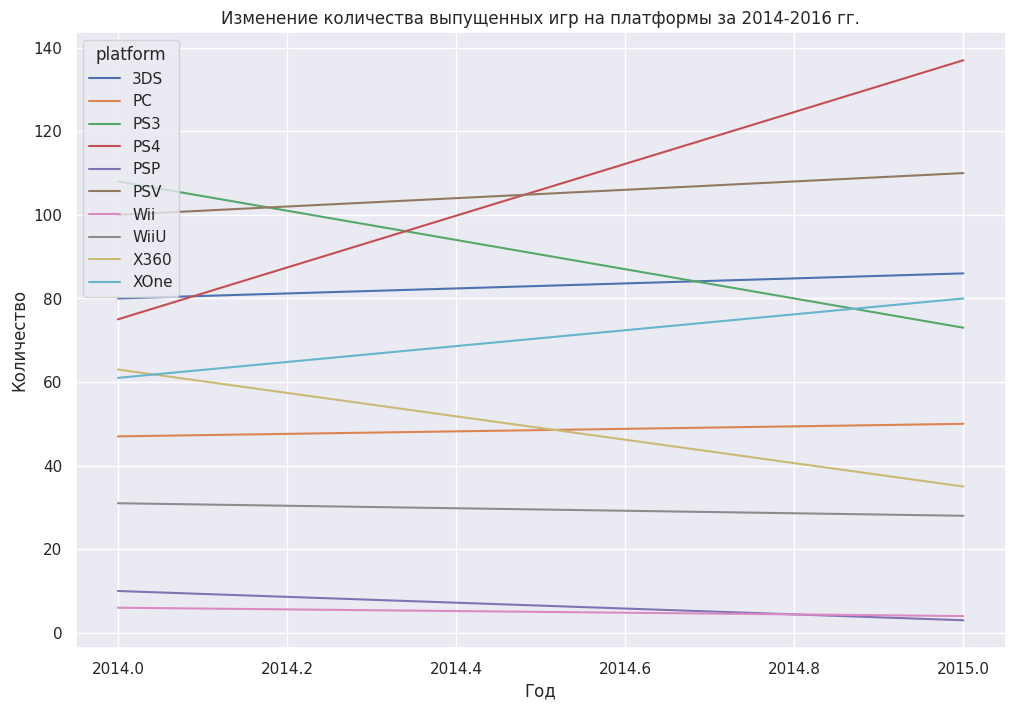

In [140]:
sns.lineplot(data=pt, 
             x='year_of_release', 
             y='name', 
             hue='platform').set(title = "Изменение количества выпущенных игр на платформы за 2014-2016 гг.",
                                 xlabel = "Год",
                                 ylabel = 'Количество')
plt.show()

По графику видно, что набирают популярность:
* PS4
* Xbox One
* PC

Таким образом самымы персперктивными платформами можно назвать **PS4, Xbox One, PC**, среди них лидирует PS4

Однако стоит отметить все еще популярные платформы:
* 3DS
* PSV

Остальные платформы либо сильно упали в продаж либо сильно уступают в продажах другим.

In [141]:
# best_platform = ['PS4', 'XOne', 'PC']
actual_data_platform = actual_data.copy()

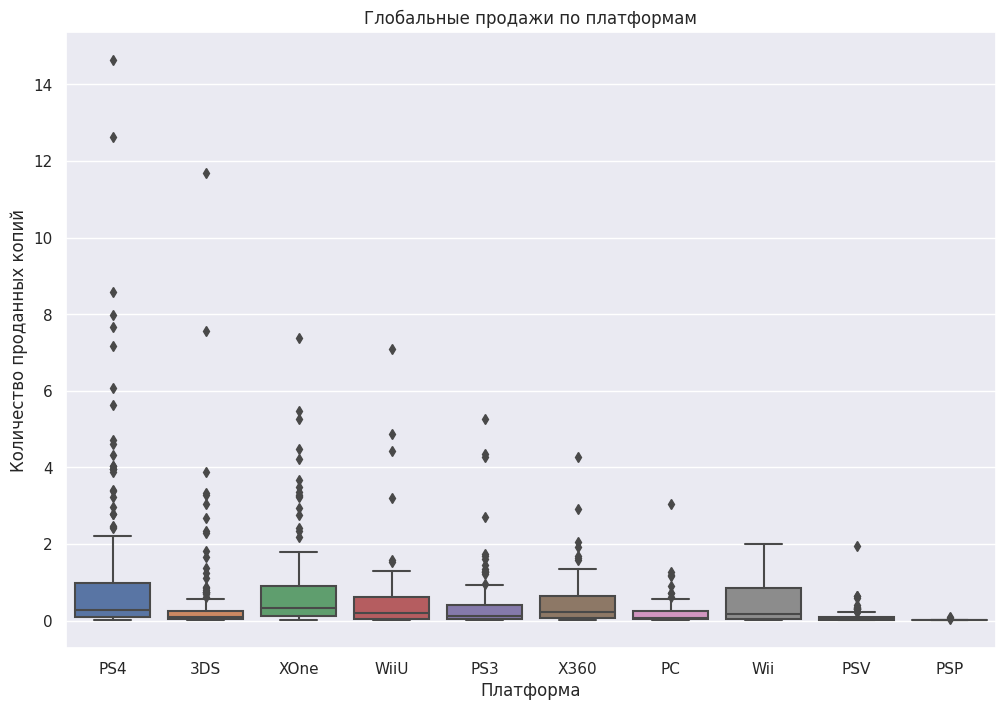

In [142]:
sns.boxplot(data=actual_data_platform, y='all_sales', x='platform').set(title="Глобальные продажи по платформам",
                                                                       xlabel="Платформа",
                                                                       ylabel="Количество проданных копий")
plt.show()

Хиты по продажам сильно портят общую картину, поэтому необходимо рассмотреть продажи, количество которых меньше 4 млн.

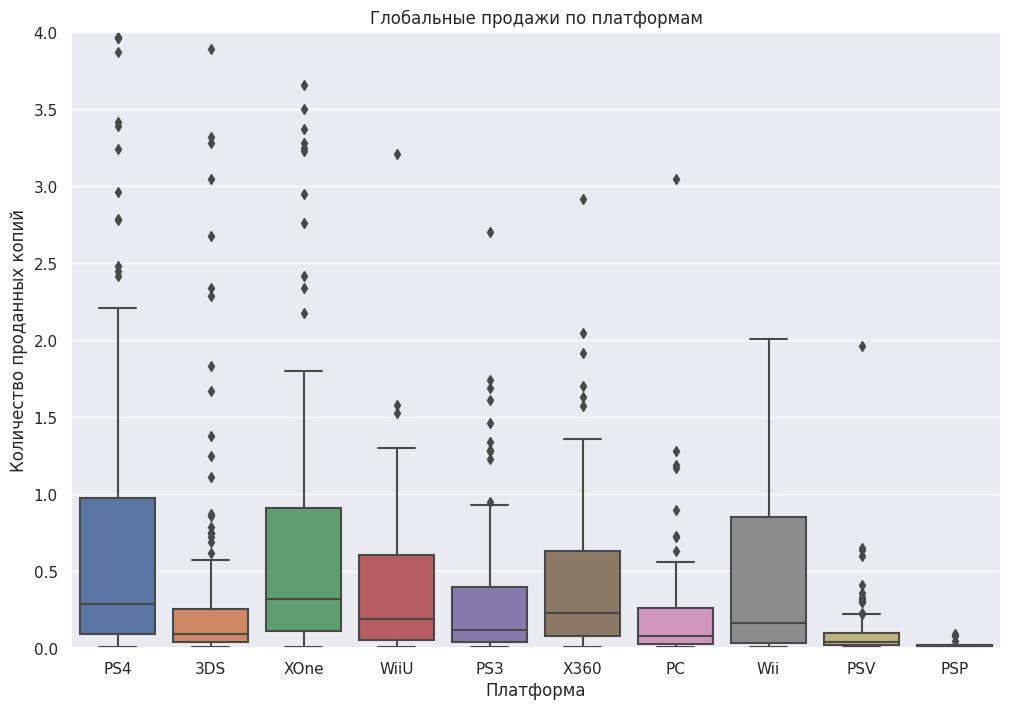

In [143]:
sns.boxplot(data=actual_data_platform, y='all_sales', x='platform').set(title="Глобальные продажи по платформам",
                                                                       xlabel="Платформа",
                                                                       ylabel="Количество проданных копий",
                                                                       ylim=(0, 4))
plt.show()

Самые высокие средние продажи на платформах:
* PS4
* XOne
* X360

Также довольно много хитов выходило на PS4, 3DS, XOne. При этом на Wii - довольно много игр с высокими продажами.

#### Как оценки критиков и пользователей влияют на продажи

In [144]:
actual_data_platform['platform'].value_counts()

platform
PS4     212
PSV     210
PS3     181
3DS     166
XOne    141
X360     98
PC       97
WiiU     59
PSP      13
Wii      10
Name: count, dtype: int64

    Для исследования была выбрана платформа PS4, т.к здесь наибольшее количество данных о играх

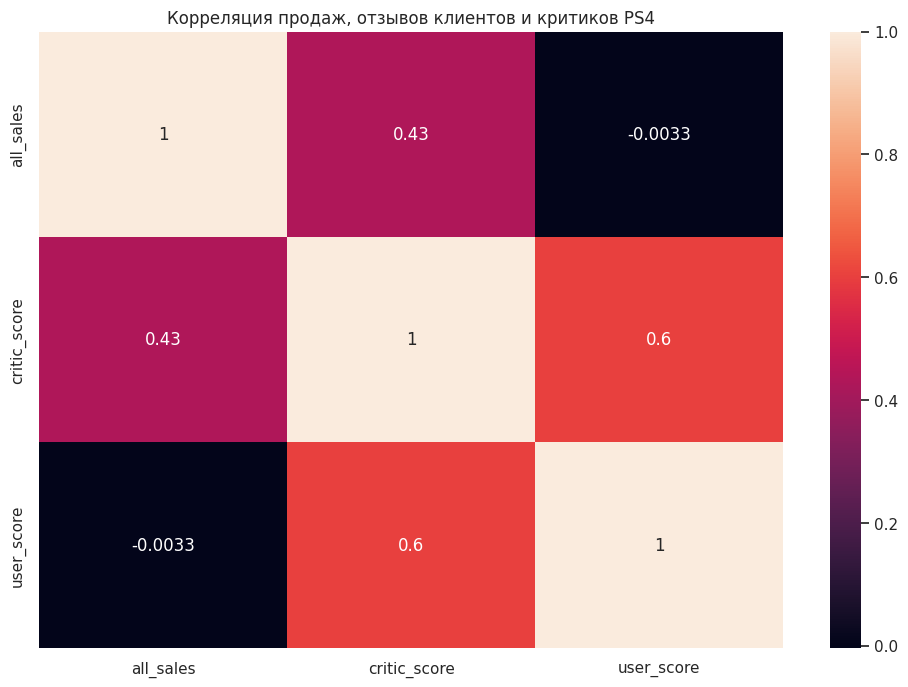

In [145]:
ps4_actual_data = actual_data_platform[actual_data_platform['platform'] == 'PS4']
ps4_actual_data = ps4_actual_data.query('user_score != 0 and critic_score != 0').reset_index(drop=True)
sns.heatmap(ps4_actual_data[['all_sales', 'critic_score', 'user_score']].corr(), annot=True).set(title="Корреляция продаж, отзывов клиентов и критиков PS4")
plt.show()

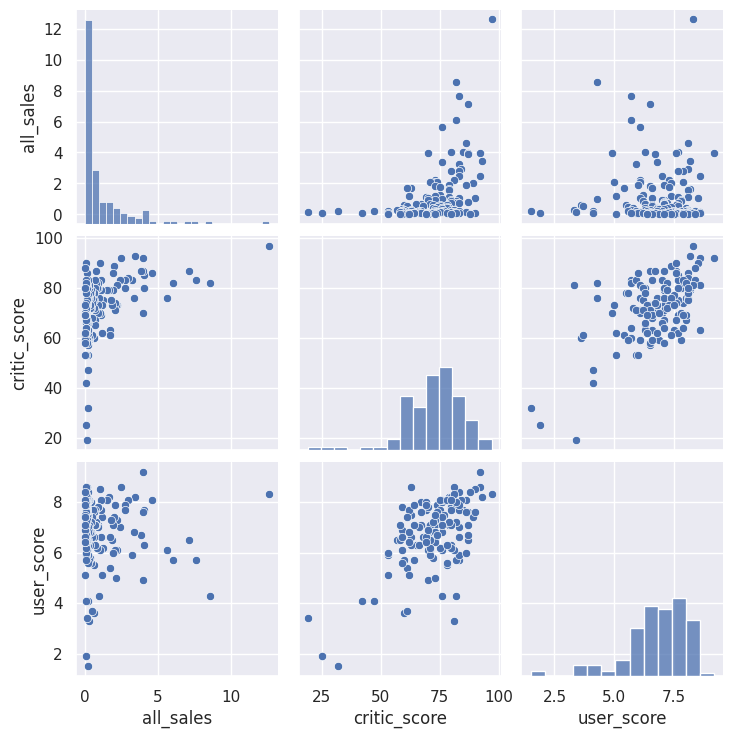

In [146]:
sns.pairplot(ps4_actual_data[['all_sales', 'critic_score', 'user_score']])
plt.show()

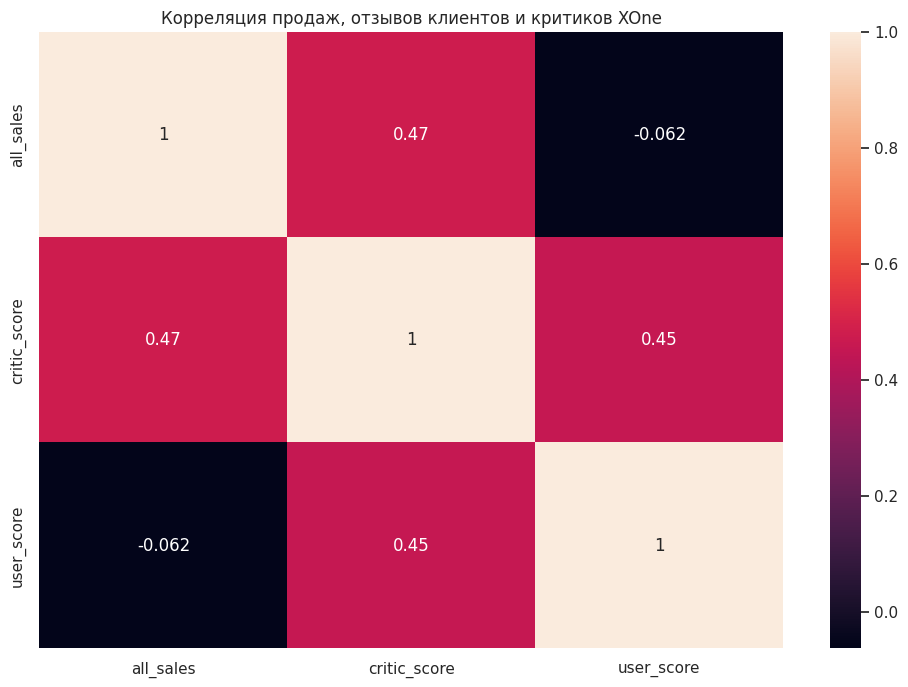

In [147]:
xone_actual_data = actual_data_platform[actual_data_platform['platform'] == 'XOne']
xone_actual_data = xone_actual_data.query('user_score != 0 and critic_score != 0').reset_index(drop=True)
sns.heatmap(xone_actual_data[['all_sales', 'critic_score', 'user_score']].corr(), annot=True).set(title="Корреляция продаж, отзывов клиентов и критиков XOne")
plt.show()

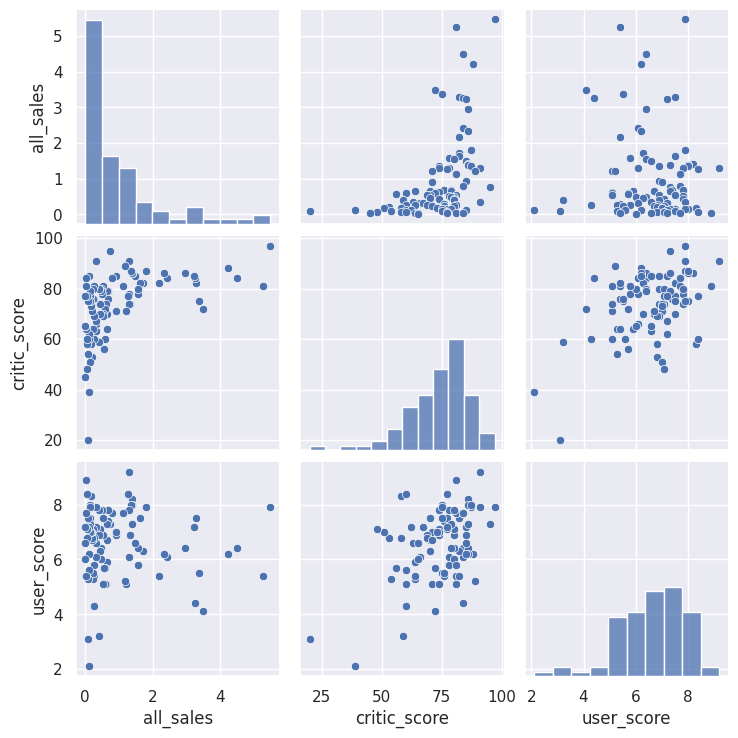

In [148]:
sns.pairplot(xone_actual_data[['all_sales', 'critic_score', 'user_score']])
plt.show()

#### Вывод
Исходя из диаграмм, можно сделать вывод, что продажи игр зависят не зависят от оценок пользователей, но наблюдается зависимость продаж от оценок критиков. Однако, наблюдается корреляция между оценками критиков и оценками пользователей.

#### Как жанр игры влияет на ее продажи.

In [149]:
top_genres = actual_data_platform['genre'].value_counts().head()
top_genres

genre
Action          441
Role-Playing    167
Adventure       129
Sports          113
Shooter          81
Name: count, dtype: int64

Было решено взять топ 5 платформ, а остально занести в категорию **другие**

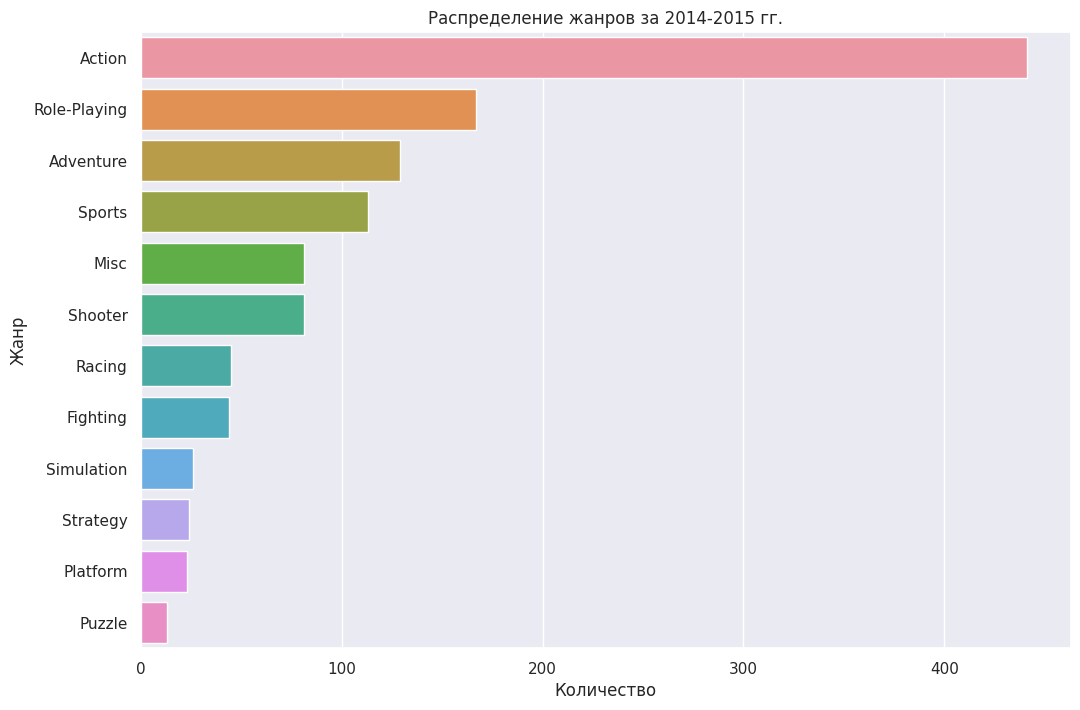

In [150]:
genres = pd.pivot_table(actual_data_platform, index='genre', aggfunc={'name':'count'})
genres.columns = ['count']
genres = genres.sort_values(by='count', ascending=False)
sns.barplot(data=genres, y=genres.index, x='count').set(title="Распределение топ 5 жанров за 2014-2015 гг.",
                                                       xlabel="Количество",
                                                       ylabel="Жанр")
plt.title("Распределение жанров за 2014-2015 гг.")
plt.show()


Самымое большое количество игр являеются игры в жанрах: **Action, Shooter, Sports**

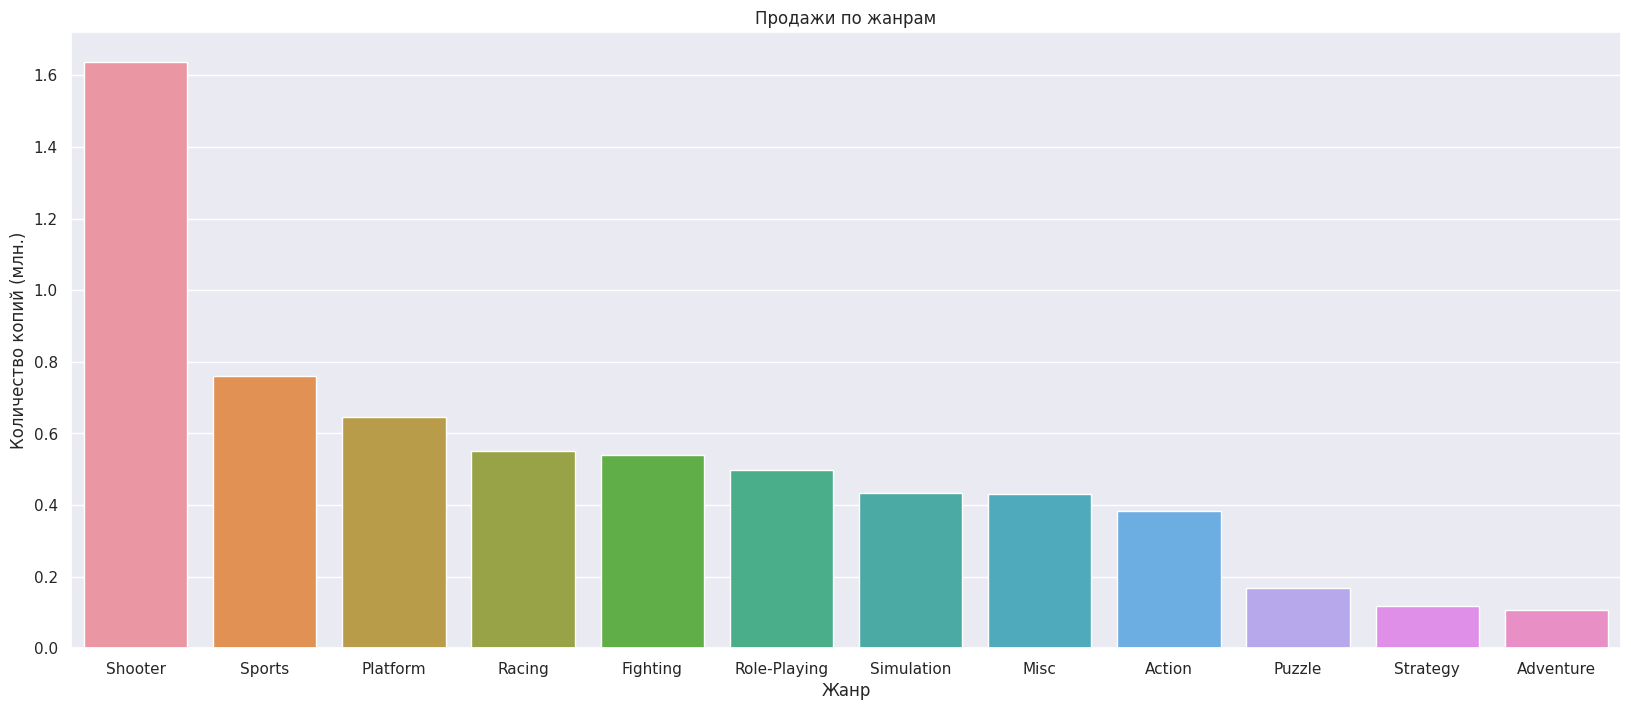

In [151]:
sns.set(rc={'figure.figsize':(20,8)})
sales_by_genre = pd.pivot_table(actual_data_platform, 
                                index='genre', values=['all_sales'], 
                                aggfunc=[sum, len])
sales_by_genre.columns = ['sum', 'count']
sales_by_genre['mean'] = sales_by_genre['sum'] / sales_by_genre['count']
sales_by_genre = sales_by_genre.sort_values(by='mean', ascending=False)
sales_by_genre
sns.barplot(data=sales_by_genre, x=sales_by_genre.index, y='mean').set(title="Продажи по жанрам", 
                                                                       xlabel="Жанр", 
                                                                       ylabel="Количество копий (млн.)")
plt.show()

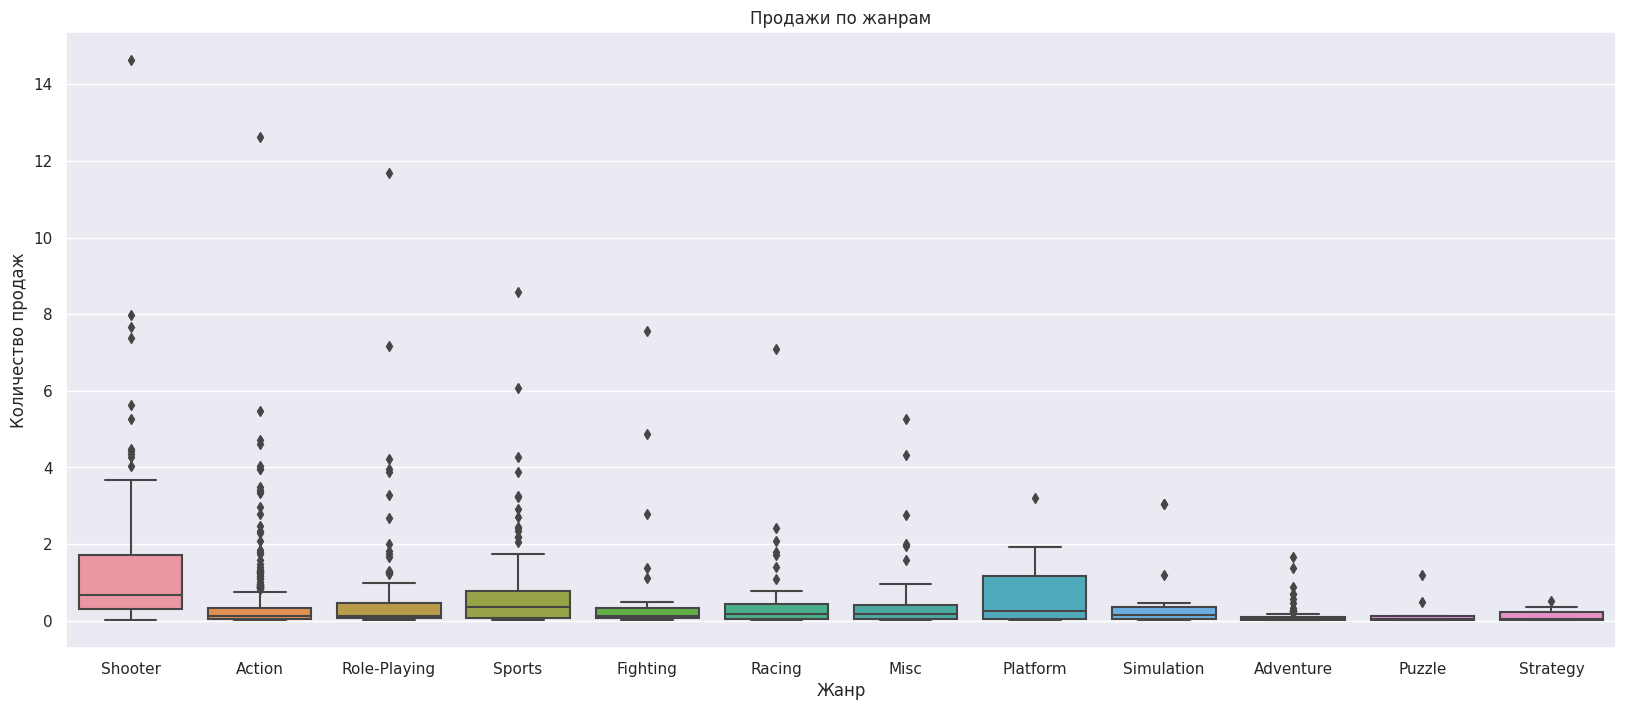

In [152]:
sns.boxplot(data=actual_data_platform, x='genre',y='all_sales').set(title="Продажи по жанрам",
                                                                    xlabel="Жанр",
                                                                    ylabel='Количество продаж')
plt.show()

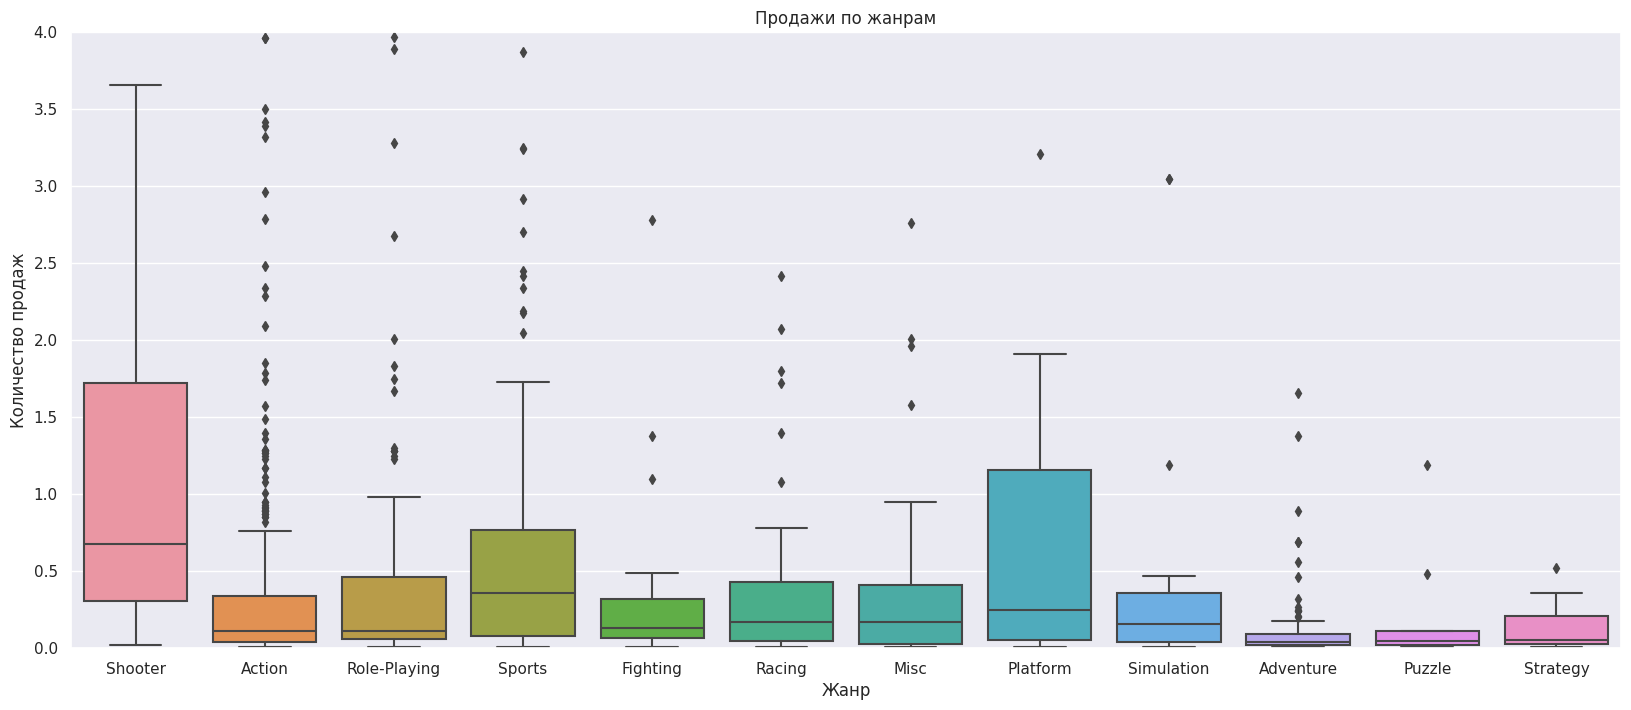

In [153]:
sns.boxplot(data=actual_data_platform, x='genre',y='all_sales').set(title="Продажи по жанрам",
                                                                    xlabel="Жанр",
                                                                    ylabel='Количество продаж',
                                                                    ylim=(0, 4))
plt.show()

### Вывод

Самыми продаваемыми играми являются игры в жанрах: **Shooter, Sports, Platform**

Наименее продаваемые - **Strategy, Adventure, Puzzle**
Также стоит отметить, что в среднем Shooter'ы по продажам превосходят все другие жанры, также у них очень большая вероятность, что количество продаж будет выше чем в других жанрах. Стоит также отметить жанр Platform и Sports. В жанре Platform редко выходят хиты, которые продаются больше своих коллег. А жанр Sports имеет хорошие показатели продаж в среднем и также иногда выходят хиты. 

### Анализ регионов. Платформы



In [154]:
years = df[df['year_of_release'] > 2000]['year_of_release'].unique().tolist()
years.sort()

best_na_platform_by_year = pd.DataFrame()
best_eu_platform_by_year = pd.DataFrame()
best_jp_platform_by_year = pd.DataFrame()

def set_data_to_df(region, df1, year):
    global df
    global best_na_platform_by_year
    global best_eu_platform_by_year
    global best_jp_platform_by_year
    
    tmp_df = df1.copy()
    tmp_df['percent'] = tmp_df[region] / df[df['year_of_release'] == year][region].sum() * 100
    tmp_df = tmp_df.sort_values(by='percent', ascending=False).head(5)
    if region == 'na_sales':
        best_na_platform_by_year = pd.concat([best_na_platform_by_year, tmp_df['percent']])
    elif region == 'eu_sales':
        best_eu_platform_by_year = pd.concat([best_eu_platform_by_year, tmp_df['percent']])
    elif region == 'jp_sales':
        best_jp_platform_by_year = pd.concat([best_jp_platform_by_year, tmp_df['percent']])

regions = ['na_sales', 'eu_sales', 'jp_sales']

for year in years:
    tmp_df = df[df['year_of_release'] == year]
    tmp_df = tmp_df.groupby(['platform'])[regions].sum()
    tmp_df
    for region in regions:
        set_data_to_df(region, tmp_df, year)

def set_year():
    tmp = []
    for year in years:
        for i in range(5):
            tmp.append(year)
    return tmp

best_na_platform_by_year['year'] = [x for x in set_year()]
best_na_platform_by_year.reset_index(inplace=True)
best_na_platform_by_year.columns = ['platform','percent', 'year']

best_eu_platform_by_year['year'] = [x for x in set_year()]
best_eu_platform_by_year.reset_index(inplace=True)
best_eu_platform_by_year.columns = ['platform','percent','year']

best_jp_platform_by_year['year'] = [x for x in set_year()]
best_jp_platform_by_year.reset_index(inplace=True)
best_jp_platform_by_year.columns = ['platform','percent', 'year']

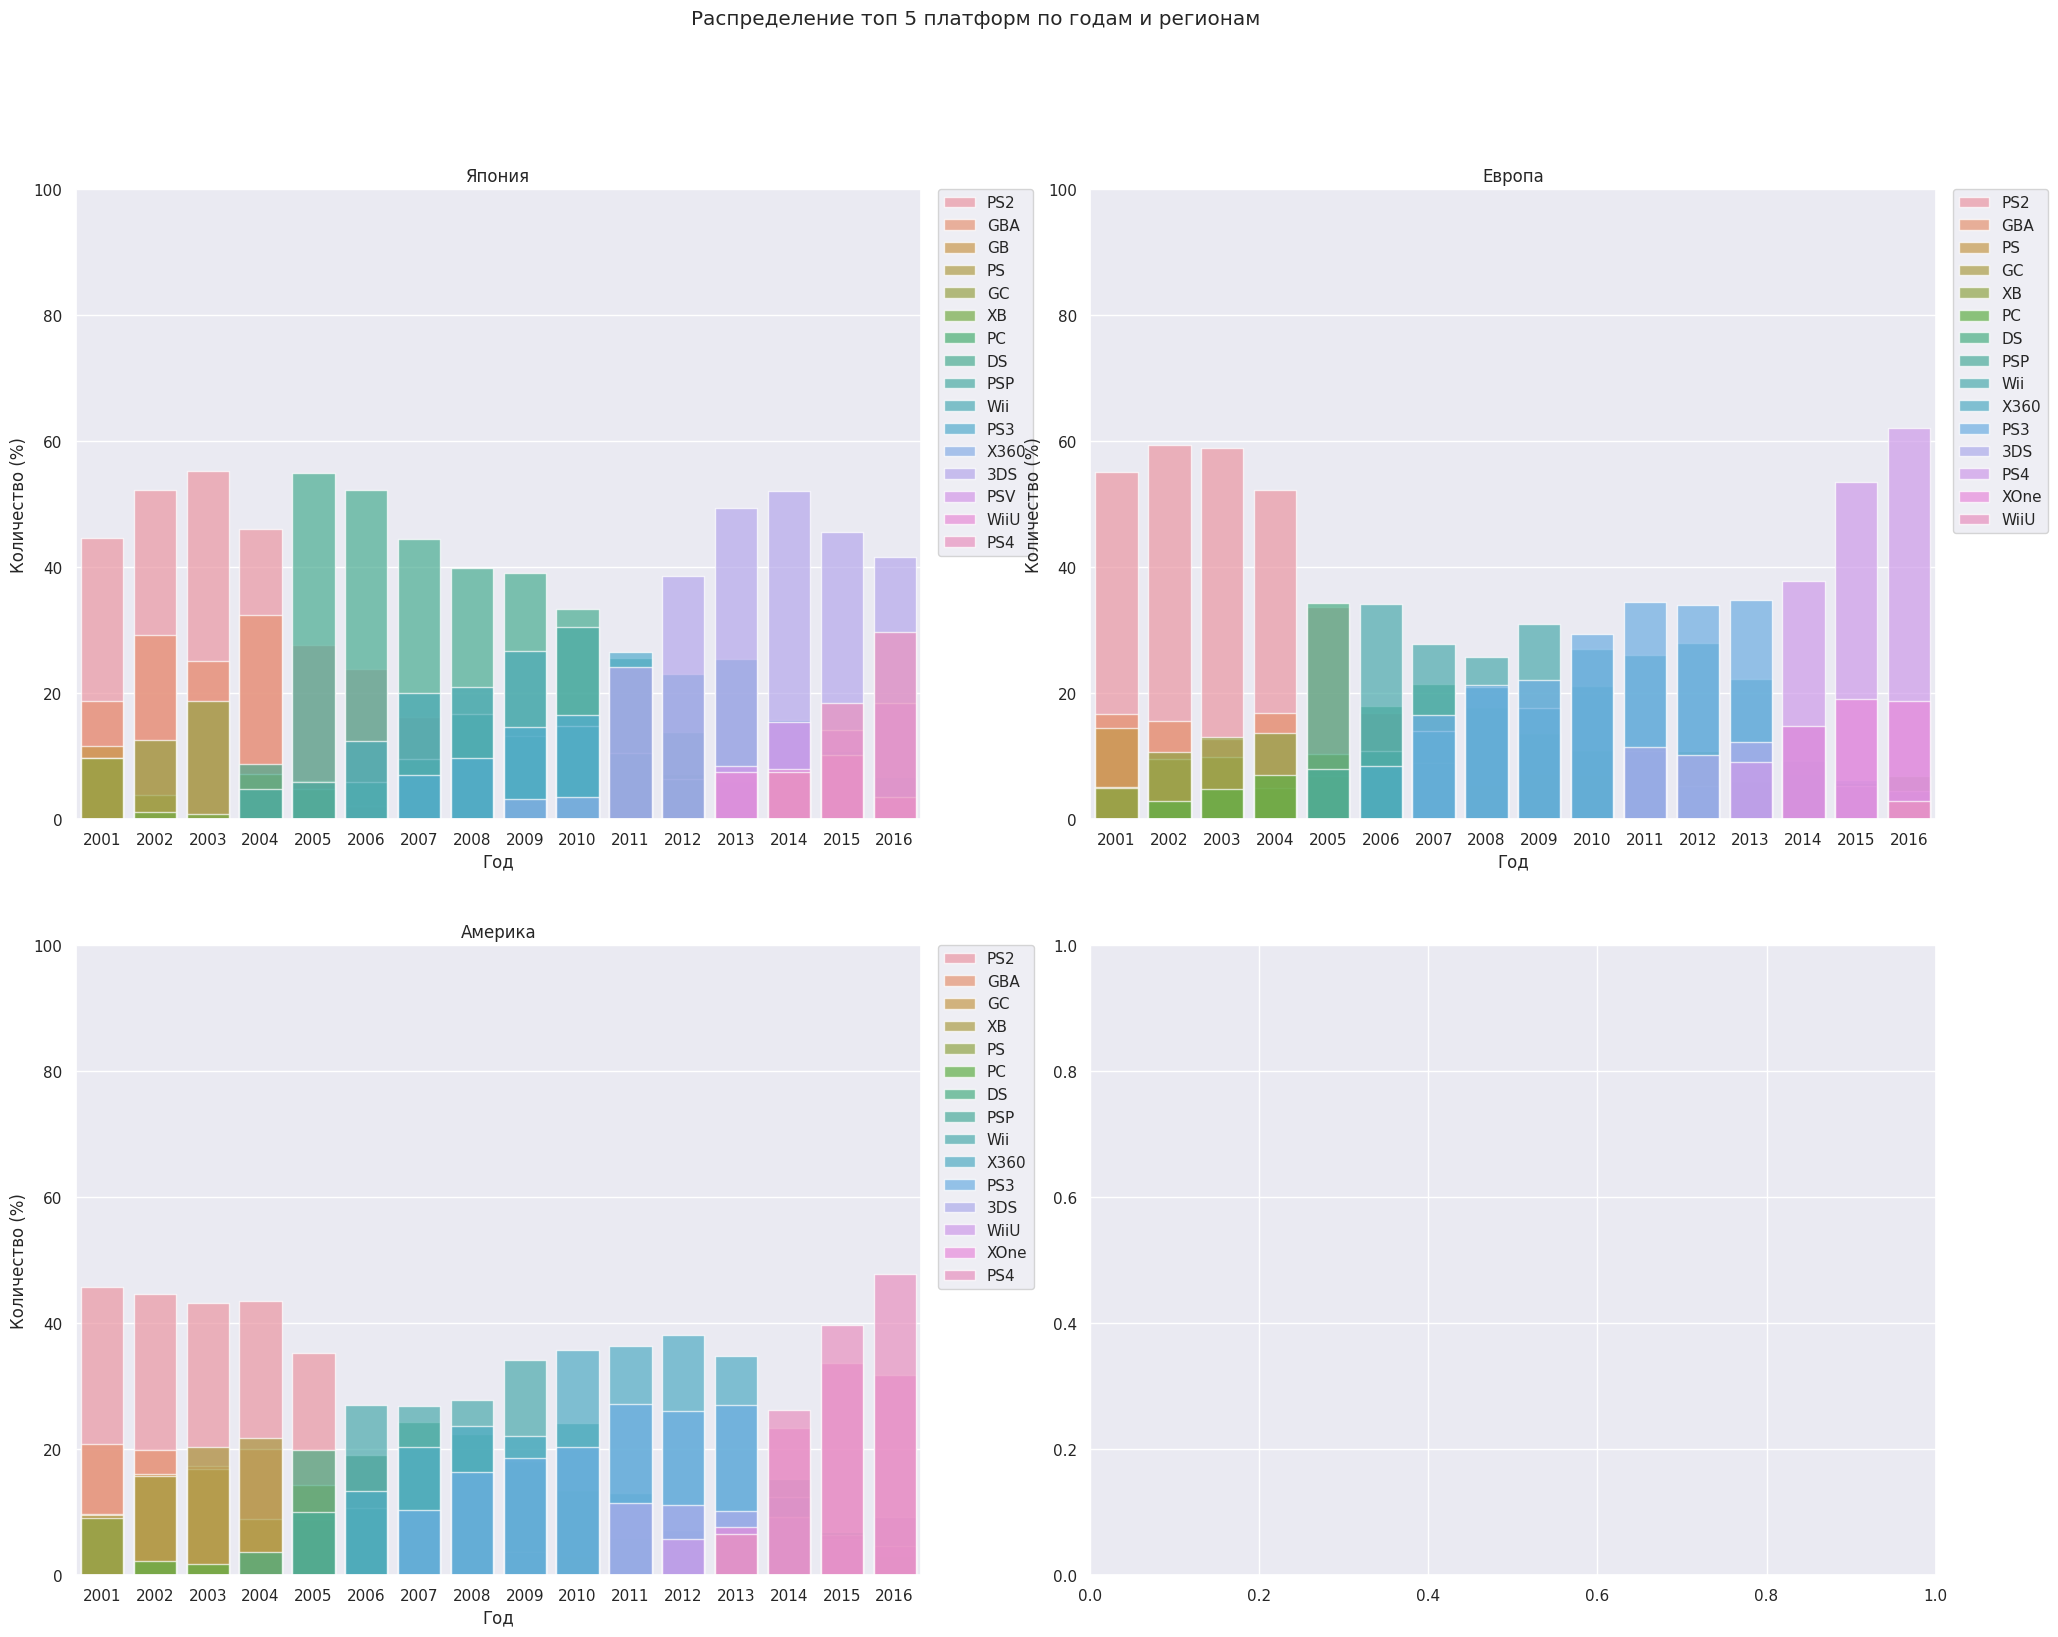

In [155]:
fig, axes = plt.subplots(2, 2, figsize=(24,18))
fig.suptitle('Распределение топ 5 платформ по годам и регионам')
sns.barplot(data=best_jp_platform_by_year,
            x='year', 
            y='percent', 
            hue='platform', 
            dodge=False, 
            alpha=0.7,
            ax=axes[0][0]).set(ylim=(0, 100),
                           xlabel="Год",
                           ylabel="Количество (%)",
                           title="Япония")
axes[0][0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

sns.barplot(best_eu_platform_by_year,
            x='year', 
            y='percent', 
            hue='platform', 
            dodge=False, 
            alpha=0.7,
            ax=axes[0][1]).set(ylim=(0, 100), 
                           xlabel="Год",
                           ylabel="Количество (%)",
                           title="Европа")
axes[0][1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

sns.barplot(best_na_platform_by_year,
            x='year', 
            y='percent', 
            hue='platform', 
            dodge=False, 
            alpha=0.7,
            ax=axes[1][0]).set(ylim=(0, 100), 
                           xlabel="Год",
                           ylabel="Количество (%)",
                           title="Америка")
axes[1][0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
                                                                                                    
plt.show()

#### Вывод 
В разных регионах популярные платформы отличается в одно и тоже время. Так к примеру за **Актуальный период** 2014-2016 гг. :
* В Европе самой популярной платформой является PS4
* В Японии - 3DS, PS4, PSV
* В Америке PS4 и Xbox One

Также разница характерна и для других периодов

### Анализ регионов. Жанры

In [156]:
years = df[df['year_of_release'] > 2000]['year_of_release'].unique().tolist()
years.sort()

best_na_genre_by_year = pd.DataFrame()
best_eu_genre_by_year = pd.DataFrame()
best_jp_genre_by_year = pd.DataFrame()

regions = ['na_sales', 'eu_sales', 'jp_sales']

def set_data_to_df2(genre, df1, year):
    global df
    global best_na_genre_by_year
    global best_eu_genre_by_year
    global best_jp_genre_by_year
    
    tmp_df = df1.copy()
    tmp_df['percent'] = tmp_df[region] / df[df['year_of_release'] == year][region].sum() * 100
    tmp_df = tmp_df.sort_values(by='percent', ascending=False).head(5)
    if region == 'na_sales':
        best_na_genre_by_year = pd.concat([best_na_genre_by_year, tmp_df['percent']])
    elif region == 'eu_sales':
        best_eu_genre_by_year = pd.concat([best_eu_genre_by_year, tmp_df['percent']])
    elif region == 'jp_sales':
        best_jp_genre_by_year = pd.concat([best_jp_genre_by_year, tmp_df['percent']])

for year in years:
    tmp_df = df[df['year_of_release'] == year]
    tmp_df = tmp_df.groupby(['genre'])[regions].sum()
    for region in regions:
        set_data_to_df2(region, tmp_df, year)

def set_year():
    tmp = []
    for year in years:
        for i in range(5):
            tmp.append(year)
    return tmp

best_na_genre_by_year['year'] = [x for x in set_year()]
best_na_genre_by_year.reset_index(inplace=True)
best_na_genre_by_year.columns = ['genre','percent', 'year']

best_eu_genre_by_year['year'] = [x for x in set_year()]
best_eu_genre_by_year.reset_index(inplace=True)
best_eu_genre_by_year.columns = ['genre','percent','year']

best_jp_genre_by_year['year'] = [x for x in set_year()]
best_jp_genre_by_year.reset_index(inplace=True)
best_jp_genre_by_year.columns = ['genre','percent', 'year']

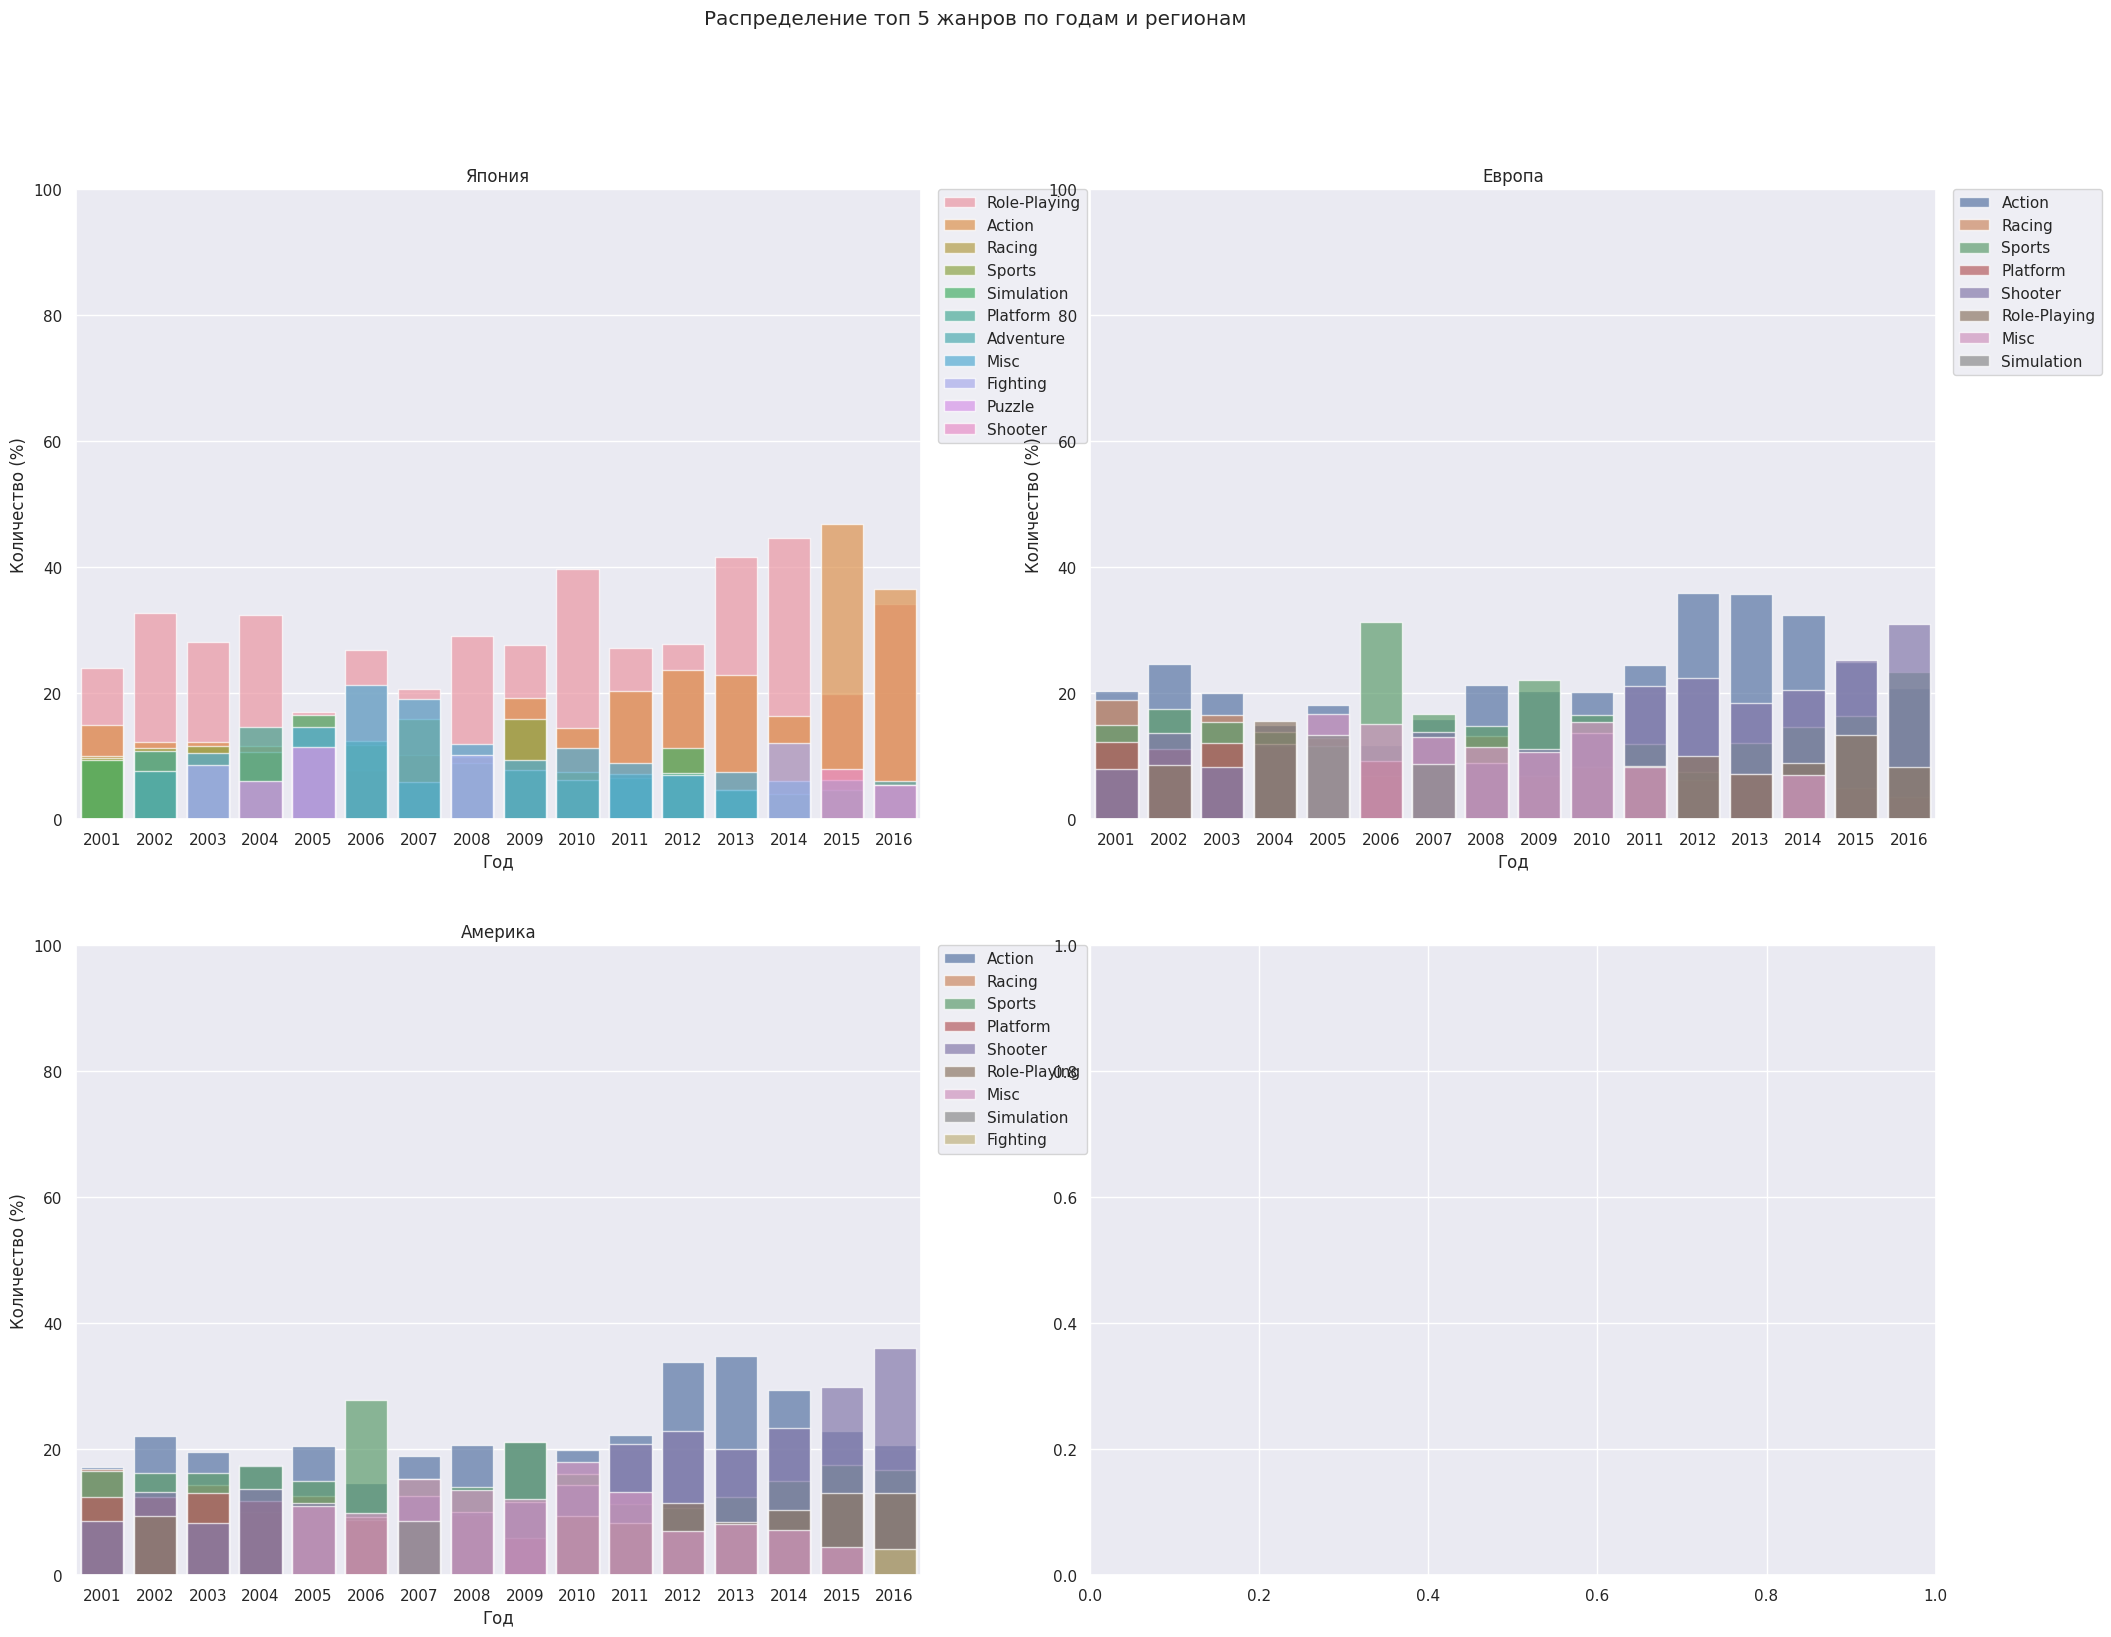

In [157]:
fig, axes = plt.subplots(2, 2, figsize=(24,18))
fig.suptitle('Распределение топ 5 жанров по годам и регионам')
sns.barplot(data=best_jp_genre_by_year,
            x='year', 
            y='percent', 
            hue='genre', 
            dodge=False, 
            alpha=0.7,
            ax=axes[0][0]).set(ylim=(0, 100),
                           xlabel="Год",
                           ylabel="Количество (%)",
                           title="Япония")
axes[0][0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

sns.barplot(best_eu_genre_by_year,
            x='year', 
            y='percent', 
            hue='genre', 
            dodge=False, 
            alpha=0.7,
            ax=axes[0][1]).set(ylim=(0, 100), 
                           xlabel="Год",
                           ylabel="Количество (%)",
                           title="Европа")
axes[0][1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

sns.barplot(best_na_genre_by_year,
            x='year', 
            y='percent', 
            hue='genre', 
            dodge=False, 
            alpha=0.7,
            ax=axes[1][0]).set(ylim=(0, 100), 
                           xlabel="Год",
                           ylabel="Количество (%)",
                           title="Америка")
axes[1][0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
                                                                                                    
plt.show()

#### Вывод

Анализируя графики, можно сказать, что японский рынок очень сильно отличается от других.
К примеру за **Актуальный период** 2014-2016 гг. :
* На рынке Америки и Европы лидируют игры в жанрах: **Shooter, Action, Role-playing**
* На рынке Японии лидируют игры в жанрах: **Action, Role-playing**

### Как влияет возрастной рейтинг игры на ее продажи 

In [158]:
sales_by_region_rating = pd.pivot_table(df, index='rating', values=['eu_sales', 'na_sales', 'jp_sales'], aggfunc=['mean'])
sales_by_region_rating

mean                    
        eu_sales  jp_sales  na_sales
rating                              
AO      0.610000  0.000000  1.260000
E       0.177983  0.049992  0.324537
E10+    0.132761  0.028310  0.248817
EC      0.013750  0.000000  0.191250
M       0.309642  0.041100  0.478874
RP      0.090643  0.124417  0.183343
T       0.144218  0.051131  0.256586

In [159]:
sales_by_region_rating_s = sales_by_region_rating.reset_index()
sales_by_region_rating_s.columns = ['rating', 'eu', 'jp', 'na']
sales_by_region_rating_s

,rating,eu,jp,na
0,AO,0.610000,0.000000,1.260000
1,E,0.177983,0.049992,0.324537
2,E10+,0.132761,0.028310,0.248817
3,EC,0.013750,0.000000,0.191250
4,M,0.309642,0.041100,0.478874
5,RP,0.090643,0.124417,0.183343
6,T,0.144218,0.051131,0.256586


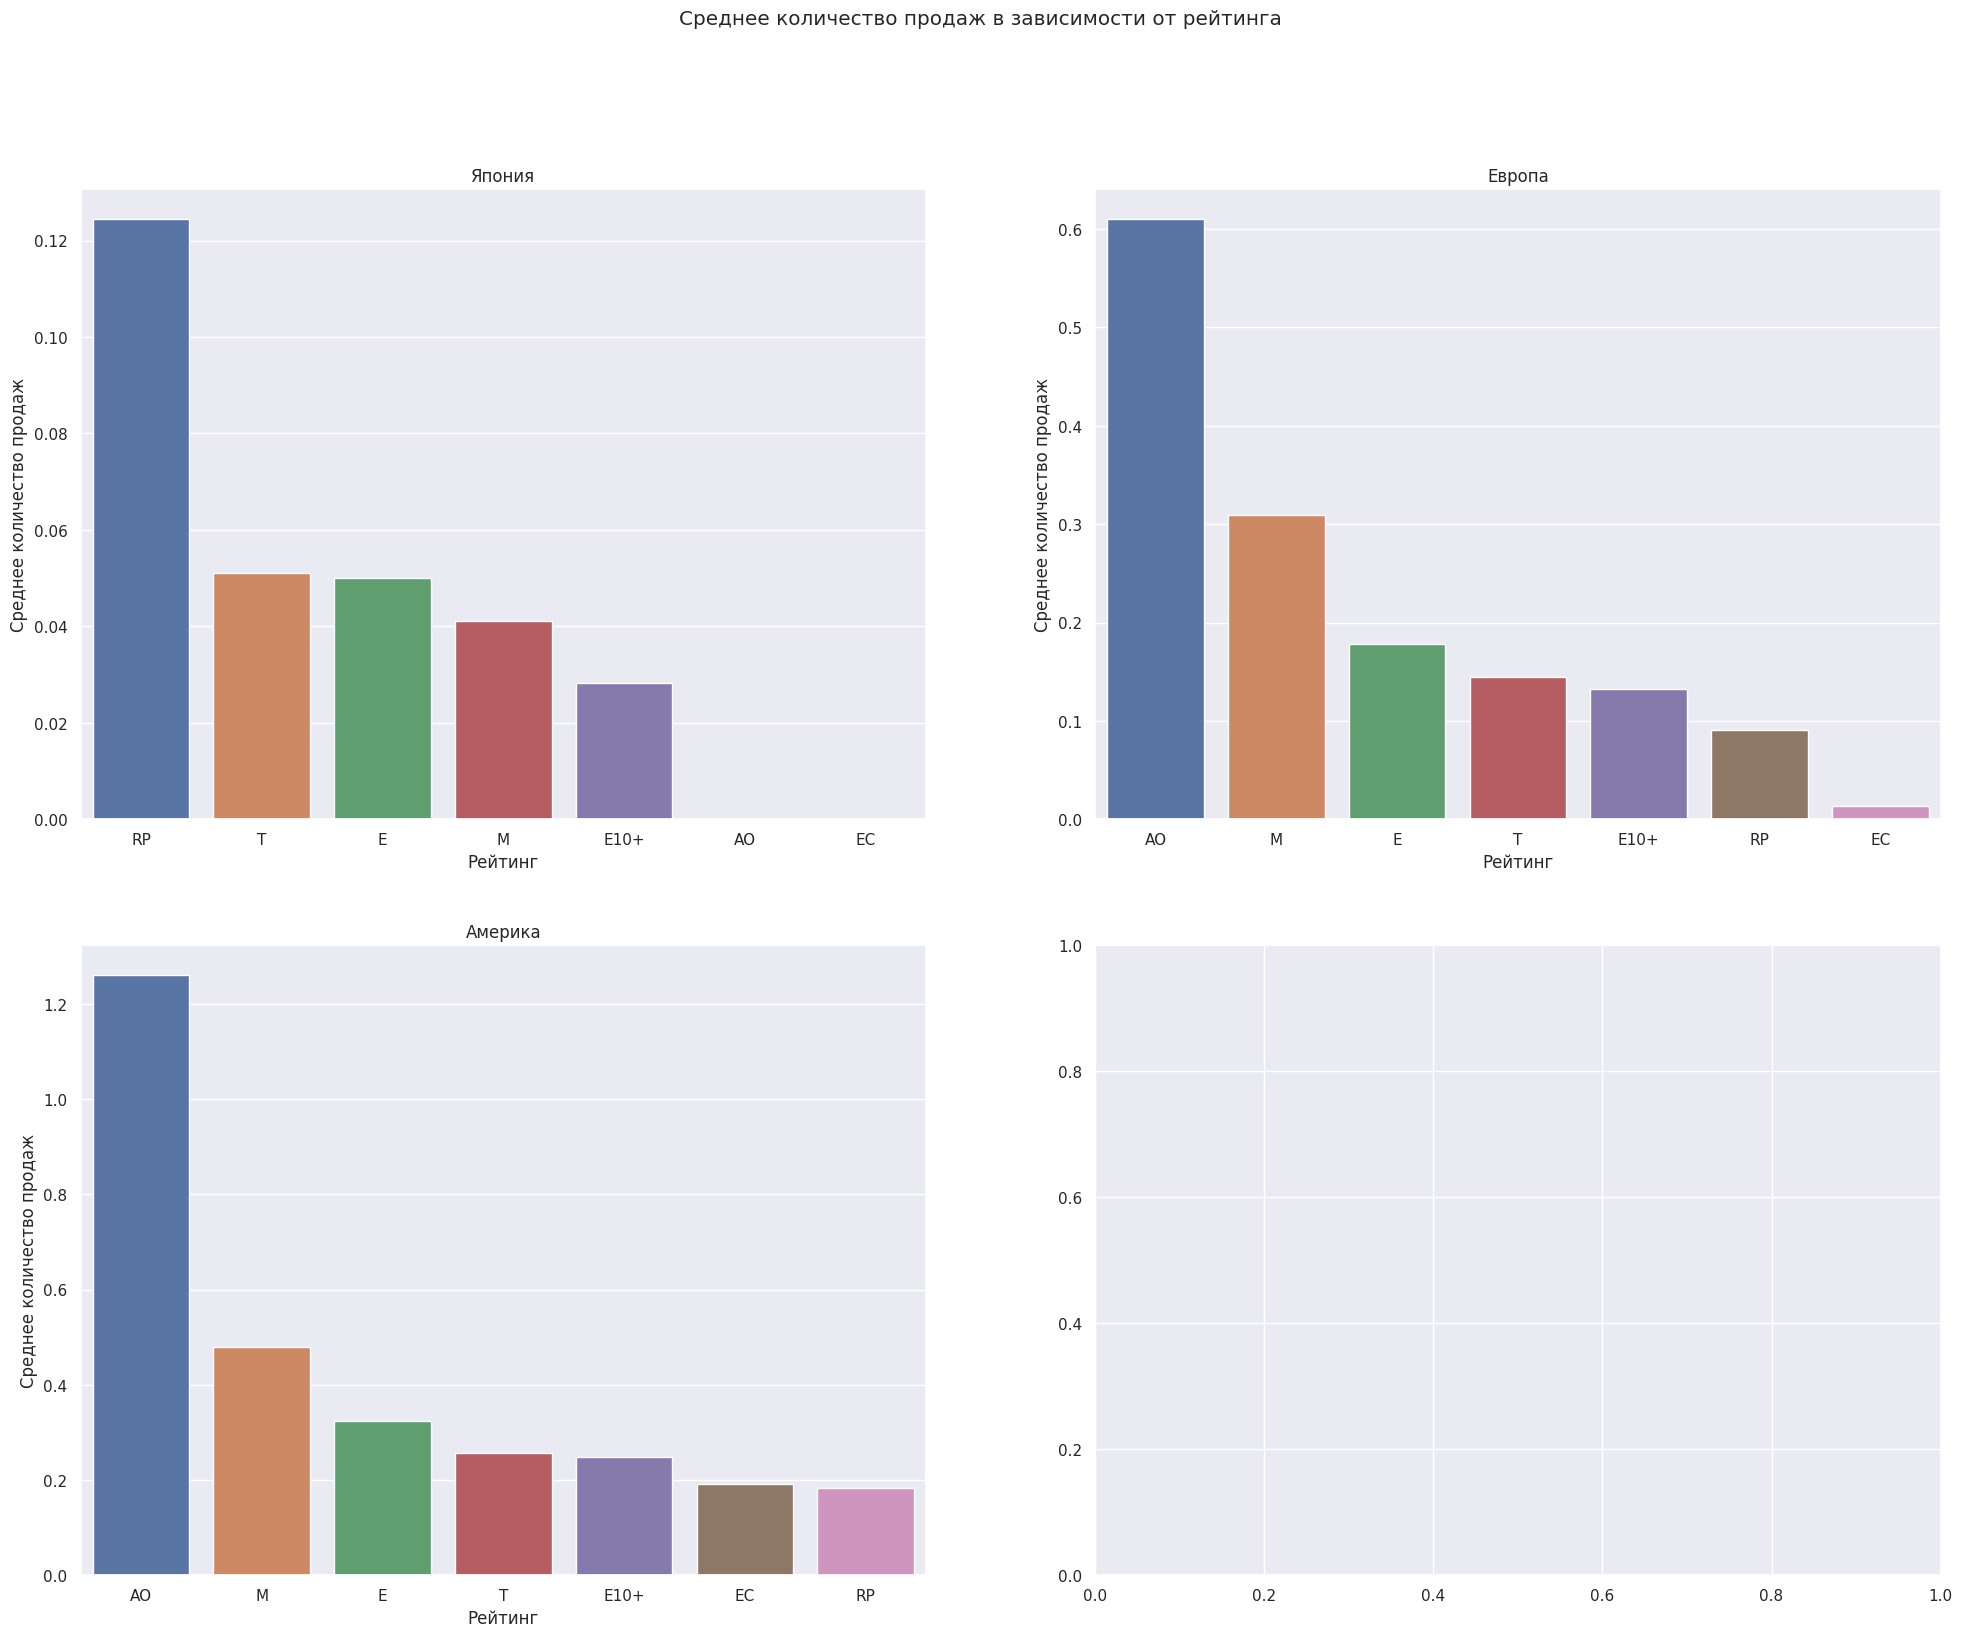

In [160]:
fig, axes = plt.subplots(2, 2, figsize=(24,18))
fig.suptitle('Среднее количество продаж в зависимости от рейтинга')
sns.barplot(data=sales_by_region_rating_s[['rating','jp']].sort_values(by='jp', ascending=False), 
            x='rating', 
            y='jp',
            ax=axes[0][0]).set(xlabel='Рейтинг', ylabel='Среднее количество продаж', title="Япония")

sns.barplot(data=sales_by_region_rating_s[['rating','eu']].sort_values(by='eu', ascending=False), 
            x='rating', 
            y='eu',
            ax=axes[0][1]).set(xlabel='Рейтинг', ylabel='Среднее количество продаж', title="Европа")

sns.barplot(data=sales_by_region_rating_s[['rating','na']].sort_values(by='na', ascending=False), 
            x='rating', 
            y='na',
            ax=axes[1][0]).set(xlabel='Рейтинг', ylabel='Среднее количество продаж', title="Америка")
                                                                                                    
plt.show()

#### Вывод

Возрастной рейтинг влияет на количество продаж игр, что в целом не удивительно.

* В Европе и Америке самыми продаваемыми являются игры с возрастным рейтингом Adults Only 18+, т.к под эту категорию попадают многие популярные жанры в этих регионах.
* В Японии же самыми продаваемыми играми являются игры с возрастным рейтингом Everyone и Teen т.к на мой взгляд это связано с жанрами, которые популярны в этом регионе. А также возможно это связано с законами. Adults Only 18+ - полностью отсутвуют в данном регионе.

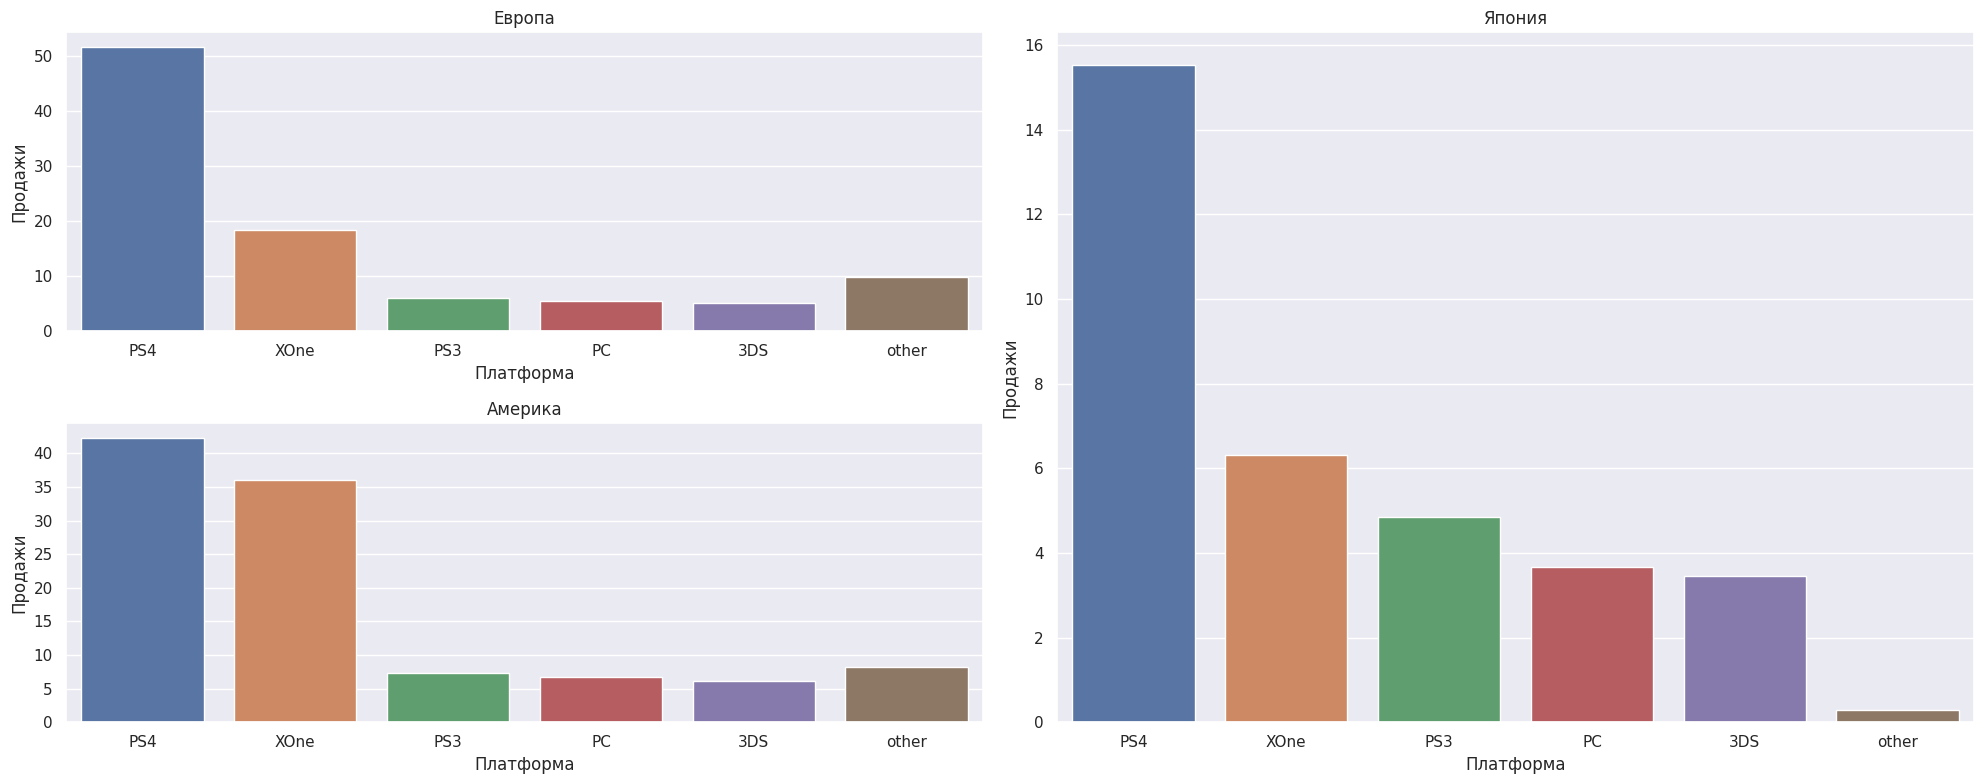

In [161]:
fig.suptitle('Распределение платформ за 2015 г. по регионам')
 
plt.subplot(2, 2, 1)
sns.barplot(x=top5_2015_eu_s.index, y=top5_2015_eu_s[0]).set(xlabel='Платформа', ylabel='Продажи', title="Европа")

plt.subplot(2, 2, 3)
sns.barplot(x=top5_2015_eu_s.index, y=top5_2015_na_s[0]).set(xlabel='Платформа', ylabel='Продажи', title="Америка")

plt.subplot(1, 2, 2)
sns.barplot(x=top5_2015_eu_s.index, y=top5_2015_jp_s[0]).set(xlabel='Платформа', ylabel='Продажи', title="Япония")
                
plt.tight_layout()     
plt.show()

### Проверка гипотез. Средние оценки для Xbox One и PC.

* Нулевая гипотеза - Средние пользовательские рейтинги платформ Xbox One и PC равны.
* Альтернативная гипотеза - Средние пользовательские рейтинги платформ Xbox One и PC не равны.
* Статистическая значимость - 0.05

Используем двусторонний ttest для двух независимых выборок.

In [162]:
aplha = .05
selection_1 = df[(df['platform']=='XOne') & (df['year_of_release'] >= 2014)]['user_score']
selection_1 = selection_1[selection_1.notna()]

selection_2 = df[(df['platform']=='PC') & (df['year_of_release'] >= 2014)]['user_score']
selection_2 = selection_2[selection_2.notna()]

results = st.ttest_ind(selection_1, selection_2)
print('p-значение:', results.pvalue)

p-значение: 0.10450507919348415


#### Вывод
В результате проведения t-теста было полученое p-value чуть больше 0.1, что говорит нам о том, что хоть оценки пользователей на платформах *XOne и PC* неодинаковы, однако мы не можем сделать вывод о значимом различии основываясь на результатах t-теста. 

* Нулевая гипотеза - Средние пользовательские рейтинги жанров Action и Sports равны.
* Альтернативная гипотеза - Средние пользовательские рейтинги платформ Xbox One и PC не равны.
* Статистическая значимость - 0.05

Используем двусторонний ttest для двух независимых выборок.

In [163]:
selection_3 = df[df['genre']=='Action']['user_score']
selection_3 = selection_3[selection_3.notna()]

selection_4 = df[df['genre']=='Sports']['user_score']
selection_4 = selection_4[selection_4.notna()]
results = st.ttest_ind(selection_3, selection_4)
print('p-значение:', results.pvalue)

p-значение: 0.10920697079316032


#### Вывод
В результате проведения t-теста было полученое p-value чуть больше 0.1, что говорит нам о том, что хоть оценки пользователей в жанрах *Action и Sports* неодинаковы, однако мы не можем сделать вывод о значимом различии основываясь на результатах t-теста.

### В ходе анализа данных была проделана следущая работа:

#### Предобработка:
    1. Были измененны название атрибутов.
    2. Некоторы данные имели не корректный формат, было произведено привидение типов.
    3. Были обработаны пропуски, заменены или удалены неизвестные значения.
#### Исследовательсикй анализ:
    Было проанализировано количество выпущенных игр по годам:
        - было выявлено, что игровая индустрия активно начала наращивать темы с 2000 г.

    На основе полученных результатов был выбран текущий актуальныый период 2014-2015 гг.
   
    Были выявлены потенциально прибыльное платформы - PS4, Xbox One, PC, 3DS, PSV
    Было выявлено, что оценки критиков влияют на продажи, чего не скажешь о оценках пользователей, корреляции обнаружено не было.
    Сымыми прибыльные жанры меняются со временем, на данный момент это - Shooter, Sports, Role-Playing, Action
   
   
Популярные платформы и жанры отличаются в зависимости от региона:

В Японии:
* Платформы - **3DS, PS4, PSV**
* Жанры - **Action, Role-playing**

В Европе и Америке:
* Платформы - **PS4, Xbox One, PC**
* Жанры - **Shooter, Action, Role-playing**
   
Также было выявлено, что возрастной рейтинг играет роль на продажи.

В Европе и Америке:
* Игры с самым продаваемым рейтингом - AO

В Японии:
* Игры с самым продаваемым рейтингом - Everyone и Teen, а также было замечено, что многие игры не имеют возрастного рейтинга.

#### Проверка гипотез
1. В ходе проверки гипотезы о том, что cредние пользовательские рейтинги платформ Xbox One и PC одинаковые, основываясь на результах теста можно говорить и том, что эту гипотезу нельзя отвергнуть.

2. В ходе проверки гипотезы о том, средние пользовательские рейтинги жанров и Sports равны, основываясь на результах теста можно говорить и том, что эту гипотезу нельзя отвергнуть.

#### Рекомендации:
Для того, чтобы прогнозировать продажи на следущие года, необходимо опираться на актульные платформы и жанры, регион продажи, возрастной рейтинг и оценки критиков. 